# Analisi dati del CRC
Questo notebook è parzialmente basato sui notebook di Antonio Iuliano: https://baltig.infn.it/iuliano/ocra_analysis/-/blob/main/CRC_Totem/CRCQuality.ipynb?ref_type=heads e https://baltig.infn.it/iuliano/ocra_analysis/-/blob/main/CRC_Totem/DisplayCRCData.ipynb?ref_type=heads

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

## Lettura dei dati
cf. https://baltig.infn.it/iuliano/ocra_analysis/-/blob/main/CRC_Totem/CRCQuality.ipynb?ref_type=heads

In [2]:
def convertdata(xnumber,verbose = False):
 '''converte i dati dal CRC in binario, con l'informazione dei piani accesi
    xnumber: numero del piano;
    verbose: se True, stampa a schermo i numeri convertiti per controllo
 '''
 nplanes = 4
 planes=[] #lista di destinazione
 for iplane in range(nplanes-1,-1,-1): #ciclo da 3 a 0
  #convertiamo i numeri da esadecimale, per ognuno dei 4 piani
  planecode = int(xnumber[2*iplane:2*iplane+2],16)
  if (verbose):
   #stampiamo le informazioni dei piani
   print(format(planecode,"#08b")) #08b è il formato binario, con gli zeri a monte lasciati per vedere i piani spenti
  planes.append(format(planecode,"#08b")) #aggiungiamo il piano alla lista di uscita
 return planes 

In [3]:
muondata = pd.read_csv("./CRC-4 LNGS 28-04-2025 16-19-57.txt",header=None,sep=" ",dtype=str)
# muondata.columns = ["Event Number","YZview","XZview","Time"] #first Y, then X
### NB: Usare la linea seguente per i dati acquisiti con l'app >=v2.10
muondata.columns = ["Event Number","XZview","YZview","Date","Time","AM/PM","Meta"] #first Y, then X
muondata.head()

,Event Number,XZview,YZview,Date,Time,AM/PM,Meta
0,6148,20202020,02020404,28/4/2025,04:19:59.268,PM,"_;_;_;_;_;0,9805807;0°"
1,6149,20080201,02020100,28/4/2025,04:19:59.723,PM,"_;_;_;_;_;0,6963106;104°"
2,6150,02040408,08040201,28/4/2025,04:20:00.803,PM,"_;_;_;_;_;0,8638684;210°"
3,6151,02081020,04040202,28/4/2025,04:20:01.210,PM,"_;_;_;_;_;0,8268982;252°"
4,6152,20202010,04040202,28/4/2025,04:20:01.885,PM,"_;_;_;_;_;0,9701425;143°"


In [4]:
# Some rows have bad data (less than 8 hex digits)
quality_selection = np.bitwise_and([len(str(x))==8 for x in muondata["XZview"]], [len(str(x))==8 for x in muondata["YZview"]])
print('Length before quality selection:', len(muondata))
muondata = muondata[quality_selection]
print('Length after quality selection:', len(muondata))

Length before quality selection: 8733
Length after quality selection: 8727


In [5]:
muondata["XZdecoded"]=muondata["XZview"].apply(convertdata)
muondata["YZdecoded"]=muondata["YZview"].apply(convertdata)
muondata.head()

,Event Number,XZview,YZview,Date,Time,AM/PM,Meta,XZdecoded,YZdecoded
0,6148,20202020,02020404,28/4/2025,04:19:59.268,PM,"_;_;_;_;_;0,9805807;0°","[0b100000, 0b100000, 0b100000, 0b100000]","[0b000100, 0b000100, 0b000010, 0b000010]"
1,6149,20080201,02020100,28/4/2025,04:19:59.723,PM,"_;_;_;_;_;0,6963106;104°","[0b000001, 0b000010, 0b001000, 0b100000]","[0b000000, 0b000001, 0b000010, 0b000010]"
2,6150,02040408,08040201,28/4/2025,04:20:00.803,PM,"_;_;_;_;_;0,8638684;210°","[0b001000, 0b000100, 0b000100, 0b000010]","[0b000001, 0b000010, 0b000100, 0b001000]"
3,6151,02081020,04040202,28/4/2025,04:20:01.210,PM,"_;_;_;_;_;0,8268982;252°","[0b100000, 0b010000, 0b001000, 0b000010]","[0b000010, 0b000010, 0b000100, 0b000100]"
4,6152,20202010,04040202,28/4/2025,04:20:01.885,PM,"_;_;_;_;_;0,9701425;143°","[0b010000, 0b100000, 0b100000, 0b100000]","[0b000010, 0b000010, 0b000100, 0b000100]"


Definiamo un'altra funzione per ottenere le coordinate $x$, $y$ e $z$ per ogni traccia. Ricordiamo che le barre di scintillatore sono larghe 4 cm, lunghe 26 cm e distanziate verticalmente 7 cm.

In [6]:
def get_coordinates(xz_array, yz_array):
    x_array = []
    y_array = []
    z_array = []
    dx = 4
    dz = 7
    for plane in xz_array:
        data = plane[2:]
        x_pos = []
        for (idx, j) in enumerate(data):
            # Lista dei valori di x registrati su un piano (potrebbero essere più di una!)
            if j == '1':
                # Posizioni rispetto al centro di ciascuna sbarretta
                x_pos.append((idx + 1/2)*dx)
        # Aggiunge alla lista di valori di x la media calcolata sul piano
        x_array.append(np.average(x_pos))

    # Ripeti per y
    for plane in yz_array:
        data = plane[2:]
        y_pos = []
        for (idx, j) in enumerate(data):
            if j == '1':
                y_pos.append((idx + 1/2)*dx)
        y_array.append(np.average(y_pos))
    
    # La coordinata z è semplicemente il numero del piano per la distanza fra piani adiacenti
    # len(xz_array) corrisponde al numero di piani di trigger utilizzati
    z_array = np.linspace(0, len(xz_array)-1, len(xz_array))*dz

    return x_array, y_array, z_array

In [7]:
muondata[["Xcoords", "Ycoords", "Zcoords"]] = muondata.apply(
    lambda row: get_coordinates(row["XZdecoded"], row["YZdecoded"]),
    axis=1,
    result_type='expand'
)
muondata.head()

/lustrehome/fschiavone/.local/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/lustrehome/fschiavone/.local/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Event Number,XZview,YZview,Date,Time,AM/PM,Meta,XZdecoded,YZdecoded,Xcoords,Ycoords,Zcoords
0,6148,20202020,02020404,28/4/2025,04:19:59.268,PM,"_;_;_;_;_;0,9805807;0°","[0b100000, 0b100000, 0b100000, 0b100000]","[0b000100, 0b000100, 0b000010, 0b000010]","[2.0, 2.0, 2.0, 2.0]","[14.0, 14.0, 18.0, 18.0]","[0.0, 7.0, 14.0, 21.0]"
1,6149,20080201,02020100,28/4/2025,04:19:59.723,PM,"_;_;_;_;_;0,6963106;104°","[0b000001, 0b000010, 0b001000, 0b100000]","[0b000000, 0b000001, 0b000010, 0b000010]","[22.0, 18.0, 10.0, 2.0]","[nan, 22.0, 18.0, 18.0]","[0.0, 7.0, 14.0, 21.0]"
2,6150,02040408,08040201,28/4/2025,04:20:00.803,PM,"_;_;_;_;_;0,8638684;210°","[0b001000, 0b000100, 0b000100, 0b000010]","[0b000001, 0b000010, 0b000100, 0b001000]","[10.0, 14.0, 14.0, 18.0]","[22.0, 18.0, 14.0, 10.0]","[0.0, 7.0, 14.0, 21.0]"
3,6151,02081020,04040202,28/4/2025,04:20:01.210,PM,"_;_;_;_;_;0,8268982;252°","[0b100000, 0b010000, 0b001000, 0b000010]","[0b000010, 0b000010, 0b000100, 0b000100]","[2.0, 6.0, 10.0, 18.0]","[18.0, 18.0, 14.0, 14.0]","[0.0, 7.0, 14.0, 21.0]"
4,6152,20202010,04040202,28/4/2025,04:20:01.885,PM,"_;_;_;_;_;0,9701425;143°","[0b010000, 0b100000, 0b100000, 0b100000]","[0b000010, 0b000010, 0b000100, 0b000100]","[6.0, 2.0, 2.0, 2.0]","[18.0, 18.0, 14.0, 14.0]","[0.0, 7.0, 14.0, 21.0]"


## Fit lineare e calcolo delle coordinate sferiche
cf. https://baltig.infn.it/iuliano/ocra_analysis/-/blob/main/CRC_Totem/DisplayCRCData.ipynb?ref_type=heads

In [8]:
def linearfit(xarr, zarr):
    '''regressione lineare con le librerie astropy, della coppia di dati xarr zarr'''
    # inizializziamo l'algoritmo di fit
    fit = fitting.LinearLSQFitter()

    # inizializziamo il modello
    line_init = models.Linear1D()

    # facciamo la regressione (n.b. z è la variabile independente, x la variabile misurata!)
    # x = m * z + b
    fitted_line = fit(line_init, zarr, xarr)
    
    return fitted_line

In [9]:
def get_theta_phi(xarr, yarr, zarr):
    fit_xz = linearfit(xarr, zarr)
    xslope = fit_xz.slope.value

    fit_yz = linearfit(yarr, zarr)
    yslope = fit_yz.slope.value

    vx = xslope
    vy = yslope
    vz = 1

    v = math.sqrt(vx * vx + vy * vy + vz * vz)
    theta = math.degrees(math.acos(vz/v))
    phi = math.degrees(math.atan2(vy,vx))

    return theta, phi

In [10]:
muondata[["theta", "phi"]] = muondata.apply(
    lambda row: get_theta_phi(row["Xcoords"], row["Ycoords"], row["Zcoords"]),
    axis=1,
    result_type='expand'
)
muondata.head()

,Event Number,XZview,YZview,Date,Time,AM/PM,Meta,XZdecoded,YZdecoded,Xcoords,Ycoords,Zcoords,theta,phi
0,6148,20202020,02020404,28/4/2025,04:19:59.268,PM,"_;_;_;_;_;0,9805807;0°","[0b100000, 0b100000, 0b100000, 0b100000]","[0b000100, 0b000100, 0b000010, 0b000010]","[2.0, 2.0, 2.0, 2.0]","[14.0, 14.0, 18.0, 18.0]","[0.0, 7.0, 14.0, 21.0]",12.875002,90.000000
1,6149,20080201,02020100,28/4/2025,04:19:59.723,PM,"_;_;_;_;_;0,6963106;104°","[0b000001, 0b000010, 0b001000, 0b100000]","[0b000000, 0b000001, 0b000010, 0b000010]","[22.0, 18.0, 10.0, 2.0]","[nan, 22.0, 18.0, 18.0]","[0.0, 7.0, 14.0, 21.0]",NaN,NaN
2,6150,02040408,08040201,28/4/2025,04:20:00.803,PM,"_;_;_;_;_;0,8638684;210°","[0b001000, 0b000100, 0b000100, 0b000010]","[0b000001, 0b000010, 0b000100, 0b001000]","[10.0, 14.0, 14.0, 18.0]","[22.0, 18.0, 14.0, 10.0]","[0.0, 7.0, 14.0, 21.0]",33.679270,-59.036243
3,6151,02081020,04040202,28/4/2025,04:20:01.210,PM,"_;_;_;_;_;0,8268982;252°","[0b100000, 0b010000, 0b001000, 0b000010]","[0b000010, 0b000010, 0b000100, 0b000100]","[2.0, 6.0, 10.0, 18.0]","[18.0, 18.0, 14.0, 14.0]","[0.0, 7.0, 14.0, 21.0]",37.855312,-17.102729
4,6152,20202010,04040202,28/4/2025,04:20:01.885,PM,"_;_;_;_;_;0,9701425;143°","[0b010000, 0b100000, 0b100000, 0b100000]","[0b000010, 0b000010, 0b000100, 0b000100]","[6.0, 2.0, 2.0, 2.0]","[18.0, 18.0, 14.0, 14.0]","[0.0, 7.0, 14.0, 21.0]",15.945396,-126.869898


## Calcolo della distribuzione angolare
A questo punto possiamo realizzare degli istogrammi degli eventi in funzione di $\theta$ e $\phi$.

In [11]:
len(muondata)

8727

In [12]:
# Rimuoviamo le run contenenti dati cattivi (theta o phi nan)
bad_runs = np.isnan(muondata["theta"]) | np.isnan(muondata["phi"])
muondata = muondata[~bad_runs]
len(muondata)

8459

In [13]:
n_bins = 5
counts, theta_bins, phi_bins = np.histogram2d(muondata["theta"], muondata["phi"], bins=n_bins)

In [14]:
counts

array([[ 30., 181., 278., 395., 152.],
       [428., 554., 400., 567., 606.],
       [579., 748., 550., 442., 601.],
       [350., 399., 363., 218., 277.],
       [ 95.,  82.,  55.,  46.,  63.]])

Text(0, 0.5, 'Counts')

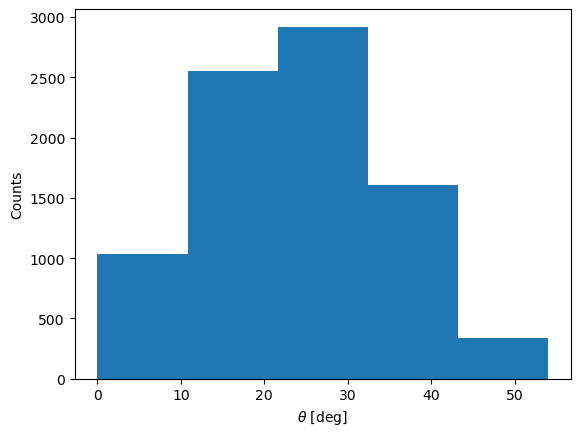

In [15]:
# Plot theta histogram
plt.hist(muondata["theta"], theta_bins)
plt.xlabel(r'$\theta$ [deg]')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

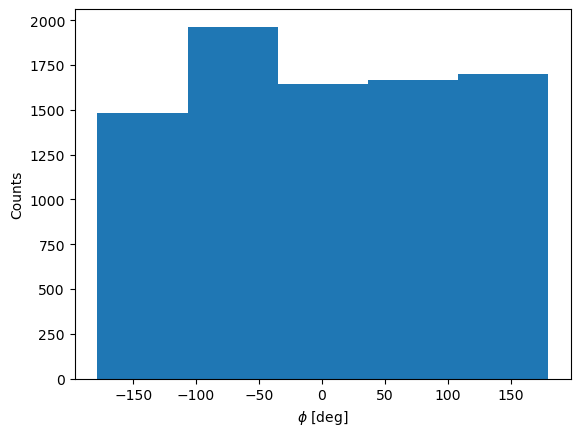

In [16]:
# Plot phi histogram
plt.hist(muondata["phi"], phi_bins)
plt.xlabel(r'$\phi$ [deg]')
plt.ylabel('Counts')

(array([[ 30., 181., 278., 395., 152.],
        [428., 554., 400., 567., 606.],
        [579., 748., 550., 442., 601.],
        [350., 399., 363., 218., 277.],
        [ 95.,  82.,  55.,  46.,  63.]]),
 array([ 0.        , 10.79920937, 21.59841874, 32.39762812, 43.19683749,
        53.99604686]),
 array([-178.56790382, -106.85432305,  -35.14074229,   36.57283847,
         108.28641924,  180.        ]),
 <matplotlib.collections.QuadMesh at 0x7f907febc6d0>)

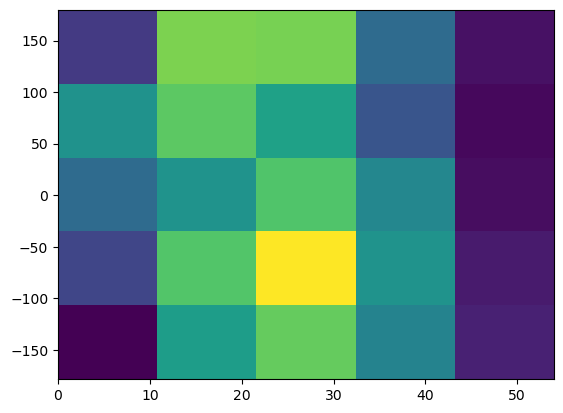

In [17]:
plt.hist2d(muondata["theta"], muondata["phi"], bins=n_bins)

## Calcolo del flusso angolare
Seguiamo la formula
$$
    \phi(\theta,\phi)=\frac{N(\theta,\phi)}{T_{\rm obs}A_{\rm eff}(\theta,\phi)\Delta\Omega}
$$

dove $N$ è il numero di conteggi, $T_{\rm obs}$ è il tempo di osservazione, $A_{\rm eff}$ è l'area efficace (vedere il notebook dedicato) e $\Delta\Omega=\sin\theta\Delta\theta\Delta\phi$ è l'elemento di angolo solido considerato.

Convertiamo tutti gli angoli in radianti e calcoliamo l'elemento di angolo solido al variare di $\theta$:


In [18]:
dtheta = np.deg2rad(np.diff(theta_bins)[0])
dphi = np.deg2rad(np.diff(phi_bins)[0])
theta_center = np.deg2rad(theta_bins[:-1] + dtheta/2)
phi_center = np.deg2rad(phi_bins[:-1] + dtheta/2)

In [19]:
domega = np.sin(theta_center)*dtheta*dphi

Calcoliamo il tempo di osservazione dalla tabella dei dati:

In [21]:
# times = muondata["Time"].astype('float')
# t = max(times) - min(times)
# print('Tempo di osservazione:', t, 's')

In [22]:
# For software version >= v2.10
from datetime import datetime
datetimes = [datetime.strptime(d+' '+t+' '+ p, '%d/%m/%Y %I:%M:%S.%f %p') for (d,t,p) in zip(muondata["Date"], muondata["Time"], muondata["AM/PM"])]
t = (max(datetimes) - min(datetimes)).total_seconds()
print('Tempo di osservazione:', t, 's')

Tempo di osservazione: 5829.408 s


Per l'area efficace, definiamo la funzione apposita, specificando le dimensioni del cubo e il numero dei piani di trigger:

In [23]:
L = 24
n = 4
def aeff(L, n, theta, phi):
    if phi < 0 or phi > np.pi/4:
        phi_original = phi
        phi = phi % (np.pi/2)             # Wrap into [0, pi/2]
        phi = min(phi, np.pi/2 - phi)     # Fold into [0, pi/4]
        # print('Converting phi:', phi_original/np.pi, 'pi ->', phi/np.pi, 'pi')
    return L**2*((1/np.cos(phi)-(n/4)*np.tan(theta))*np.cos(phi)*np.cos(theta)*(1-np.tan(phi))+(1/np.cos(phi)**2+(n**2/16)*np.tan(theta)**2-(n/(2*np.cos(phi)))*np.tan(theta))*np.cos(phi)*np.sin(phi)*np.cos(theta))

Abbiamo quindi tutti gli elementi per calcolare il flusso in funzione di $\theta$ e $\phi$:

In [24]:
flux = np.array([[None for _ in theta_center] for _ in phi_center])
dflux = np.array([[None for _ in theta_center] for _ in phi_center])

In [25]:
for (i,th) in enumerate(theta_center):
    for (j,ph) in enumerate(phi_center):
        a = aeff(L, n, th, ph)
        flux[i,j] = counts[i,j]/(t*a*domega[i])
        dflux[i,j] = np.sqrt(counts[i,j])/(t*a*domega[i])

In [26]:
np.sum(dflux**2, axis=1)

array([np.float64(0.0006129904323330786),
       np.float64(2.0124905287808288e-07),
       np.float64(1.3267251255973037e-07),
       np.float64(1.2233469114744152e-07),
       np.float64(4.216083684358218e-07)], dtype=object)

In [27]:
flux_theta = np.sum(flux, axis=1)*dphi
dflux_theta = [np.sqrt(x)*dphi for x in np.sum(dflux**2, axis=1)]

In [28]:
from scipy.optimize import curve_fit
def model(theta, p0, p1):
    return p0 + p1 * np.cos(theta)**2

popt, pcov = curve_fit(model, theta_center[1:], flux_theta[1:])
p0, p1 = popt

theta_fit = np.linspace(0, np.pi, 1000)
y_fit = model(theta_fit, *popt)

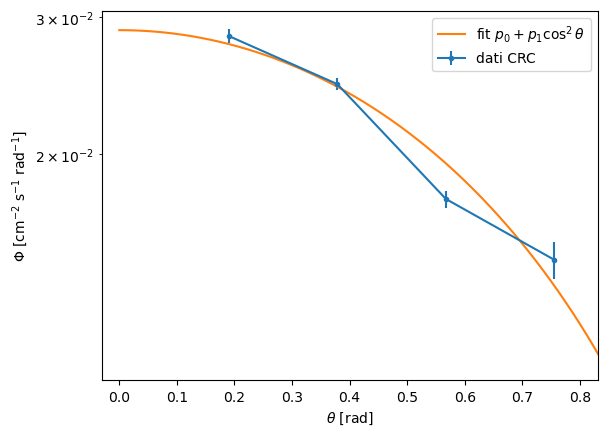

In [30]:
plt.errorbar(theta_center[1:], flux_theta[1:], yerr=dflux_theta[1:], marker='.', label='dati CRC')
# plt.errorbar(theta_center, flux_theta, yerr=dflux_theta, marker='.', label='dati CRC')
plt.plot(theta_fit, y_fit, label=r'fit $p_0 + p_1\cos^2\theta$')
plt.xlabel(r'$\theta$ [rad]')
plt.ylabel(r'$\Phi$ [cm$^{-2}$ s$^{-1}$ rad$^{-1}$]')
plt.xlim([-.03, 1.1*max(theta_center)])
plt.ylim(bottom=.7*min(flux_theta))
plt.yscale('log')
plt.legend()